In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 4000

# Load data from https://www.openml.org/d/554
X_raw, y_raw = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)



In [2]:
coef_idxs = np.array([3, 7])
X = X_raw[(y_raw=='3')|(y_raw=='7'),:] ### With two classes, the clf is binary hence only one set of coef
y = y_raw[(y_raw=='3')|(y_raw=='7')]

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)
scaler = MinMaxScaler()
X_train = 1.0 - scaler.fit_transform(X_train)
X_test = 1.0 - scaler.transform(X_test)


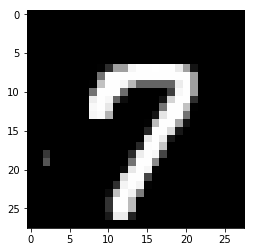

In [4]:

plt.imshow(X_train[np.random.choice(X_train.shape[0]),:].reshape(28,28), cmap=plt.cm.Greys)

In [105]:
my_penalty = "none"
# Turn up tolerance for faster convergence
clf_none = LogisticRegression(C=50.0 / train_samples, penalty=my_penalty, solver="saga", tol=0.1)
clf_none.fit(X_train, y_train)
coef_sign_= np.sign(clf_none.coef_)
sparsity = np.mean(clf_none.coef_ == 0) * 100
score = clf_none.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with " + my_penalty + " penalty: %.2f%%" % sparsity)
print("Test score with " + my_penalty + " penalty: %.4f" % score)

Sparsity with none penalty: 0.00%
Test score with none penalty: 0.9808


c:\Users\Martin\.conda\envs\python36_jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


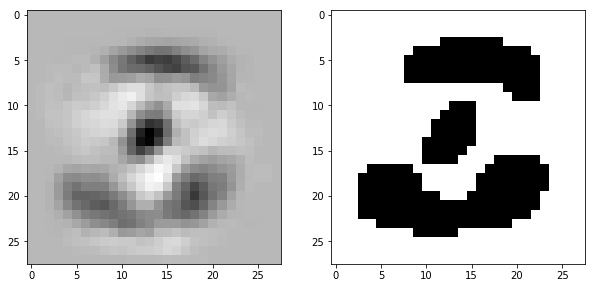

In [6]:
plt.figure(figsize=(10, 5))
spl = plt.subplot(1,2,1)
spl.imshow(clf.coef_.reshape(28,28), cmap=plt.cm.Greys)
spl = plt.subplot(1,2,2)
spl.imshow(coef_sign_.reshape(28,28), cmap=plt.cm.Greys)
plt.show()

(-0.5, 279.5, 279.5, -0.5)

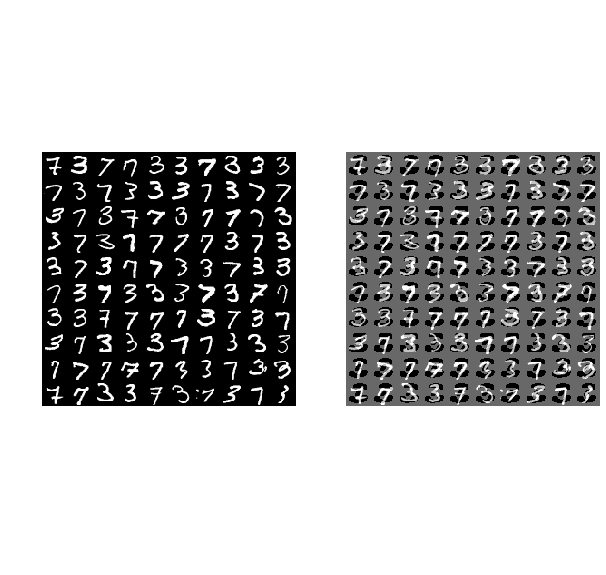

In [7]:
epsilon = 0.25
num_grid = 10
num_grid_sq = int(num_grid**2)
X_train_adv_ = X_train + epsilon*coef_sign_

X_grid = X_train[0:num_grid_sq, :].reshape(num_grid_sq, 28, 28)
X_grid_adv = X_train_adv_[0:num_grid_sq, :].reshape(num_grid_sq, 28, 28)

X_nums_grid = np.zeros((num_grid*28, num_grid*28))
X_nums_grid_adv = np.zeros((num_grid*28, num_grid*28))
for i in range(num_grid):
    n0 = 28*i
    for j in range(num_grid):
        m0 = 28*j
        idx = 10*i + j
        X_nums_grid[n0:(n0+28), m0:(m0+28)] = X_grid[idx, :, :]
        X_nums_grid_adv[n0:(n0+28), m0:(m0+28)] = X_grid_adv[idx, :, :]



plt.figure(figsize=(10, 10))
spl = plt.subplot(1,2,1)
plt.imshow(X_nums_grid, cmap=plt.cm.Greys)
plt.axis('equal')
plt.axis('off')

spl = plt.subplot(1,2,2)
plt.imshow(X_nums_grid_adv, cmap=plt.cm.Greys)
plt.axis('equal')
plt.axis('off')

In [109]:
""""Ordinary Training and Adversarial risk"""

my_penalty = "none"
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty=my_penalty, solver="saga", tol=0.1)
clf.fit(X_train, y_train)
coef_sign_= np.sign(clf.coef_)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with " + my_penalty + " penalty: %.2f%%" % sparsity)
print("Test score with " + my_penalty + " penalty: %.4f" % score)


epsilon = 0.25
X_test_adv_ = X_test + epsilon*np.sign(clf.coef_)
score = clf.score(X_test_adv_, y_test)
# print('Best C % .4f' % clf.C_)
print("Adversarial Test score with " + my_penalty + " penalty: %.4f" % score)

Sparsity with none penalty: 0.00%
Test score with none penalty: 0.9810
Adversarial Test score with none penalty: 0.5188


c:\Users\Martin\.conda\envs\python36_jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [111]:
""""Adversarial Training ?"""

my_penalty = "none"
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty=my_penalty, solver="saga", tol=0.1)
clf.fit(X_train, y_train)
coef_sign_= np.sign(clf.coef_)

epsilon = 0.25
X_train_adv = X_train + epsilon*coef_sign_

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty=my_penalty, solver="saga", tol=0.1)
clf.fit(X_train_adv, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
adv_score = clf.score(X_test + epsilon*np.sign(clf.coef_), y_test)
# print('Best C % .4f' % clf.C_)
print("Adv Training --> Sparsity with " + my_penalty + " penalty: %.2f%%" % sparsity)
print("Adv Training --> Test score with " + my_penalty + " penalty: %.4f" % score)
print("Adv Training --> Adv Test score with " + my_penalty + " penalty: %.4f" % adv_score)


# epsilon = 0.25
# X_test_adv_ = X_test + epsilon*np.sign(clf.coef_)
# score = clf.score(X_test_adv_, y_test)
# # print('Best C % .4f' % clf.C_)
# print("Adversarial Test score with " + my_penalty + " penalty: %.4f" % score)

c:\Users\Martin\.conda\envs\python36_jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
c:\Users\Martin\.conda\envs\python36_jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Adv Training --> Sparsity with none penalty: 0.00%
Adv Training --> Test score with none penalty: 0.4939
Adv Training --> Adv Test score with none penalty: 0.9762
